In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from gymnax.environments.classic_control.cartpole import EnvParams, CartPole
from rejax import get_algo
from rejax.evaluate import evaluate

import _pickle as pickle
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [2]:
config_path = "./configs/custom/cartpole.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f.read())

In [ ]:
algo_name = "ppo"
seed_id = 42
num_seeds = 50

key = jax.random.PRNGKey(seed_id)
keys = jax.random.split(key, num_seeds)
config = config[algo_name]

In [4]:
config

{'agent_kwargs': {'activation': 'tanh'},
 'num_envs': 1,
 'num_steps': 100,
 'num_epochs': 5,
 'num_minibatches': 5,
 'learning_rate': 0.00075,
 'max_grad_norm': 0.5,
 'total_timesteps': 100000,
 'eval_freq': 1000,
 'gamma': 0.99,
 'gae_lambda': 0.95,
 'clip_eps': 0.2,
 'ent_coef': 0.01,
 'vf_coef': 0.5,
 'buffer_size': 100000}

In [5]:
env = CartPole()
config["env"] = env

gravities = jax.random.uniform(key, shape=(num_seeds,))

algo_cls = get_algo(algo_name)
algo = jax.vmap(
    lambda gravity: algo_cls.create(
        **config,
        env_params=EnvParams(gravity=gravity),
    )
)(
    gravities
)


def eval_callback(algo, ts, rng):
    act = algo.make_act(ts)
    max_steps = algo.env_params.max_steps_in_episode
    return evaluate(act, rng, env, algo.env_params, 50, max_steps)

algo = algo.replace(
    eval_callback=eval_callback
)

In [6]:
vmap_train = jax.jit(jax.vmap(algo_cls.train, in_axes=(0, 0)))
ts, (_, returns) = vmap_train(algo, keys)
returns.block_until_ready()

print(None)

/home/bryanpu1/.conda/envs/aaai_rejax/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


(100, 1, 4)


AttributeError: 'Trajectory' object has no attribute 'next_obs'

In [ ]:
pickle.dump(
    {
        "buffer_info": {k: v for k, v in ts.store_buffer.__dict__.items() if k != "data"},
        "data": {k: np.array(v) for k, v in ts.store_buffer.data._asdict().items()},
        "algorithm": {
            "algo": algo_name,
            **{k: v for k, v in config.items() if k != "env"},
        },
        "env": type(config["env"]).__name__,
        "env_params": gravities,
    },
    open("learning_hist-cartpole-{}.pkl".format(algo_name), "wb"),
)

AttributeError: 'PPOState' object has no attribute 'store_buffer'

In [ ]:
assert 0

AssertionError: 

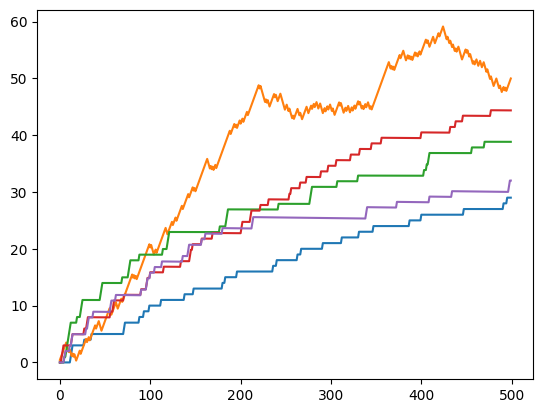

In [ ]:
regrets = (np.arange(ts.store_buffer.data.reward.shape[1])[None] + 1) * np.max(env_params, axis=-1, keepdims=True) - np.cumsum(ts.store_buffer.data.reward, axis=-1)

for regret in regrets[:5]:
    xrange = np.arange(len(regret))
    plt.plot(xrange, regret)
plt.show()


(51, 50)
(51, 50)


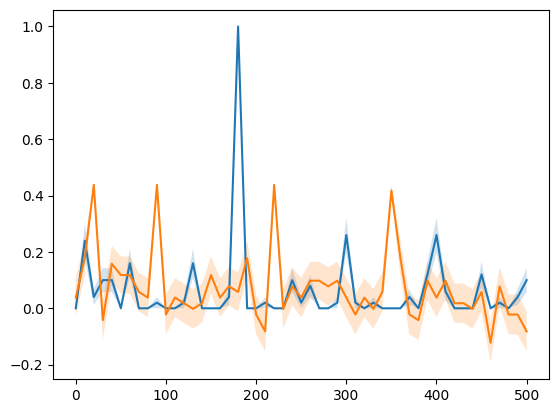

In [ ]:
for env_returns, env_param in zip(returns[:2], env_params):
    xrange = np.arange(len(env_returns)) * config["eval_freq"]
    regret = np.max(env_param, axis=-1) - env_returns
    print(regret.shape)
    mean = np.mean(regret, axis=-1)
    std = np.std(regret, axis=-1) / np.sqrt(regret.shape[-1])
    plt.plot(xrange, mean)
    plt.fill_between(xrange, mean - std, mean + std, alpha=0.2)
plt.show()


In [ ]:
for env_returns in returns[:2]:
    xrange = np.arange(len(env_returns)) * config["eval_freq"]
    mean = np.mean(env_returns, axis=-1)
    std = np.std(env_returns, axis=-1) / np.sqrt(env_returns.shape[-1])
    plt.plot(xrange, mean)
    plt.fill_between(xrange, mean - std, mean + std, alpha=0.2)
plt.show()
